In [1]:
import os
import numpy as np
import pandas as pd
import sklearn as sk
import PIL.Image as Image
from IPython import display
import pylab as pl
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from collections import Counter
import operator
import time
from skimage.transform import resize, rescale, downscale_local_mean

%matplotlib inline

Using TensorFlow backend.


### Control Variables

In [2]:
seta = "SHM"
setb = "PCY"

### Functions

In [3]:
def crop_image(img, cropx, cropy):
    return img[cropy[0]:cropy[1],cropx[0]:cropx[1]]

def load_set(set):
    if not ".csv" in set:
        csv_file_name = "%s.csv" % set
    else:
        csv_file_name = "%s" % set
    csv_path = "../data/card_data/csv"
    csv_file_path = "%s/%s" % (csv_path, csv_file_name)
        
    return pd.read_csv(csv_file_path)

def load_sets(sets):
    data = pd.DataFrame()
    for set in sets:
        try:
            set_temp = pd.DataFrame(load_set(set))
            data = data.append(set_temp)
        except:
            pass
    
    return data

def key_set_counts(data):
    flattened = np.ndarray.flatten(data)
    splita = np.array([x.split(',') for x in flattened])
    split = np.sort(np.concatenate(splita, axis=0))
    
    c = Counter([word for word in split])
    keys = np.unique(split)
    key_counts={}
    for i in range(0,keys.shape[0]):
        key_counts.update({keys[i] : c[keys[i]]})
    return key_counts

def set_card_names(set):
    data = load_set(set)
    
    return data["name"].values

def get_subtype_df(set, subtype):
    """
        Returns a dataframe containing all cards of the subtype 
        given from the sets given.
    """
    data = set[set["type"].str.contains(subtype,case=False)].drop_duplicates("name")
    return data.sort_values("printings")

def load_images_type(sets, subtype, images_path_):
    pics_raw = []
    for set in sets:
        images_path = "%s/%s" % (images_path_, set)
        #print(images_path)
        # Load subset type cards from csv lists
        try: #Try to load the given set, if it doesn't exist, pass
            card_names = get_subtype_df(load_set(set),subtype)['name'].values
            for image in card_names:
                try:
                    im_file_name = "%s.full.jpg" % image
                    #print(set, ": ", im_file_name)
                    im_file_path = "%s/%s" % (images_path, im_file_name)
                    image = np.asarray(Image.open(im_file_path))
                    image = resize(image, (310,223), mode='reflect')
                    pics_raw.append(np.asarray(image))
                except OSError:
                    pass
        except:
            pass
            
    return pics_raw

def load_image(sets, images_path_,image_num):
    pic = None
    if (not isinstance(sets,list)):
        sets = [sets]
    for set in sets:
        images_path = "%s/%s" % (images_path_, set)
        # Load subset type cards from csv lists
        try: #Try to load the given set, if it doesn't exist, pass
            card_names = load_set(set)['name'].values
            im_file_name = "%s.full.jpg" % card_names[image_num]
            # print(set, ": ", im_file_name)
            im_file_path = "%s/%s" % (images_path, im_file_name)
            image = np.asarray(Image.open(im_file_path))
            image = resize(image, (310,223), mode='reflect')
            return image
            
#             for image in card_names:
#                 try:
#                     im_file_name = "%s.full.jpg" % image
#                     # print(set, ": ", im_file_name)
#                     im_file_path = "%s/%s" % (images_path, im_file_name)
#                     image = np.asarray(Image.open(im_file_path))
#                     image = resize(image, (310,223), mode='reflect')
#                     return image
#                 except OSError:
#                     print("Error in load_image")
        except:
            pass
            
    return pic

def load_images(sets, images_path_):
    pics_raw = []
    if (not isinstance(sets,list)):
        sets = [sets]
    for set in sets:
        images_path = "%s/%s" % (images_path_, set)
        # Load subset type cards from csv lists
        try: #Try to load the given set, if it doesn't exist, pass
            card_names = load_set(set)['name'].values
            for image in card_names:
                try:
                    im_file_name = "%s.full.jpg" % image
                    # print(set, ": ", im_file_name)
                    im_file_path = "%s/%s" % (images_path, im_file_name)
                    image = np.asarray(Image.open(im_file_path))
                    image = resize(image, (310,223), mode='reflect')
                    pics_raw.append(image)
                except OSError:
                    pass
        except:
            pass
            
    return pics_raw

def filter_set_dims(sets, images_path):
    sets_new = []
    for set in sets:
        try:
            print("Set: %s" % set)
            temp_images = load_images(set,images_path)
            test_image = temp_images[1]
            if ((test_image.shape[0] == (310 or 311)) and (test_image.shape[2] == 3)):
                sets_new.append(set)
        except:
            pass

    return sets_new

### Load Card Data

In [4]:
# Path to card csv data, not images
csv_path = "../data/card_data/csv"

# List of all files in the csv directory
#  This is essentially a list of the names of all MTG sets
#  We will loop through all the names of the files and load them into memory
#  to have a single dataframe with every card from every set.
filelist = os.listdir(csv_path)
data_sets = load_sets(filelist).fillna("none")

In [5]:
# Quick exploration
print("Number of cards: %d" % data_sets.shape[0])

Number of cards: 30833


### Examine Specific Card Type
We will be looking at the elf creature subtype. Filtering on all cards that contain the subtype elf, so we have a dataframe that contains only elves.

In [6]:
# Filter based on type containing 'elf'
card_type = "elf"
elves_all = get_subtype_df(data_sets, card_type)
# Get all sets that contain elves
elf_sets = elves_all["printings"].values

print("Number of unique %s cards: %d" %(card_type, elves_all.shape[0]))
elves_all

Number of unique elf cards: 305


name         manaCost cmc colorIdentity  \
98      Viridian Lorebearers           {3}{G}   4             G   
99            Viridian Scout           {3}{G}   4             G   
88              Joiner Adept           {1}{G}   2             G   
123        Behemoth's Herald              {G}   1             G   
126               Cylian Elf           {1}{G}   2             G   
127       Druid of the Anima           {1}{G}   2         G,R,W   
132               Godtoucher           {3}{G}   4           G,W   
134     Keeper of Progenitus           {3}{G}   4             G   
145      Sacellum Godspeaker           {2}{G}   3             G   
178         Mayael the Anima        {R}{G}{W}   3         W,R,G   
56            Fyndhorn Druid           {2}{G}   3             G   
235              Elvish Bard        {3}{G}{G}   5             G   
158      Elvish Spirit Guide           {2}{G}   3             G   
169                    Kaysa        {3}{G}{G}   5             G   
157            Elvish Ranger           {2}{G}   3             G   
100           Gaea's Skyfolk           {G}{U}   2           U,G   
108            Llanowar Dead           {B}{G}   2           B,G   
89                Urborg Elf           {1}{G}   2         G,U,B   
11          Sylvan Messenger           {3}{G}   4             G   
54        Godtracker of Jund        {1}{R}{G}   3           R,G   
102       Sages of the Anima        {3}{G}{U}   5           U,G   
140           Naya Hushblade         {R/W}{G}   2         W,R,G   
245       Beastcaller Savant           {1}{G}   2          none   
176         Lifespring Druid           {2}{G}   3             G   
192       Tajuru Beastmaster           {5}{G}   6             G   
193          Tajuru Stalwart           {2}{G}   3             G   
194         Tajuru Warcaller        {3}{G}{G}   5             G   
211       Grovetender Druids        {2}{G}{W}   4           W,G   
219             Skyrider Elf        {X}{G}{U}   2           U,G   
43   Ezuri, Claw of Progress        {2}{G}{U}   4           U,G   
..                       ...              ...  ..           ...   
115         Vastwood Animist           {2}{G}   3             G   
159                Arbor Elf              {G}   1             G   
190        Turntimber Ranger        {3}{G}{G}   5             G   
171       Oracle of Mul Daya           {3}{G}   4             G   
22             Tajuru Archer           {2}{G}   3             G   
16               Joraga Bard           {3}{G}   4             G   
11            Frontier Guide           {1}{G}   2             G   
163        Greenweaver Druid           {2}{G}   3             G   
81            Coiling Oracle           {G}{U}   2          none   
50         Elvish Aberration           {5}{G}   6          none   
201        Imperious Perfect           {2}{G}   3             G   
10       Bramblewood Paragon           {1}{G}   2             G   
129         Elvish Visionary           {1}{G}   2             G   
49            Bloodbraid Elf        {2}{R}{G}   4           R,G   
18     Wren's Run Vanquisher           {1}{G}   2             G   
172            Elvish Mystic              {G}   1             G   
110            Glistener Elf              {G}   1             G   
17       Wilt-Leaf Cavaliers  {G/W}{G/W}{G/W}   3           W,G   
100          Deranged Hermit        {3}{G}{G}   5             G   
202         Joraga Warcaller              {G}   1             G   
26       Trostani's Summoner        {5}{G}{W}   7          none   
24          Zameck Guildmage           {G}{U}   2          none   
193         Reclamation Sage           {2}{G}   3             G   
100         Allosaurus Rider        {5}{G}{G}   7             G   
226    Wren's Run Packmaster           {3}{G}   4             G   
95       Glissa, the Traitor        {B}{G}{G}   3           B,G   
239          Elvish Champion        {1}{G}{G}   3             G   
121          Naya Sojourners     {2}{R}{G}{W}   5         W,R,G   
215 

### Find Set Occurences
Show sets that contain elves, sorted by how many elves are in each set.
This is important because we only want to extract images for the sets with the most number of elf cards, reducing our memory footprint.

In [7]:
# Show sorted set counts of elves
elf_set_counts = key_set_counts(elf_sets)
for w in sorted(elf_set_counts, key=elf_set_counts.get, reverse=True):
    print(w, elf_set_counts[w])

LRW 24
C14 24
EVG 20
DD3_EVG 19
DPA 17
SHM 17
ONS 17
EMA 16
ORI 14
MOR 13
LGN 12
10E 11
C15 11
RAV 10
pFNM 9
9ED 9
7ED 9
8ED 9
ALA 8
VMA 8
INV 8
CNS 7
UDS 7
SCG 7
MRD 7
BFZ 7
ZEN 7
SOM 6
RTR 6
GTC 6
USG 6
CMD 6
FUT 5
M13 5
BRB 5
OGW 5
6ED 5
ARB 5
TSP 5
ME2 5
ULG 5
PO2 5
S99 5
5ED 5
C13 5
ALL 5
PLS 4
APC 4
POR 4
M10 4
M11 4
DGM 4
ARC 4
ICE 4
M15 4
DDP 4
ROE 4
EVE 4
TMP 4
CON 4
pMGD 3
pWPN 3
DDE 3
pGTW 3
5DN 3
M12 3
M14 3
DDJ 3
MBS 3
WWK 3
DIS 3
DST 3
PC2 3
NPH 3
EXO 3
pPRE 3
FEM 3
4ED 3
MMA 2
NMS 2
PLC 2
MM2 2
S00 2
LEA 2
2ED 2
LEB 2
ME3 2
WTH 2
ITP 2
CSP 2
BTD 2
pCMP 2
CEI 2
pARL 2
CED 2
DDH 2
RQS 2
DKM 2
pSUS 2
GPT 2
LEG 2
3ED 2
DRK 2
STH 2
VIS 2
pJGP 1
CM1 1
DDG 1
V13 1
DDO 1
MIR 1
CHR 1
TPR 1
MED 1
TSB 1
DDD 1
DD3_GVL 1
ATH 1
UNH 1
pLPA 1


### Examine Subset

In [ ]:
get_subtype_df(data_sets, 'elf')

name         manaCost cmc colorIdentity  \
98      Viridian Lorebearers           {3}{G}   4             G   
99            Viridian Scout           {3}{G}   4             G   
88              Joiner Adept           {1}{G}   2             G   
123        Behemoth's Herald              {G}   1             G   
126               Cylian Elf           {1}{G}   2             G   
127       Druid of the Anima           {1}{G}   2         G,R,W   
132               Godtoucher           {3}{G}   4           G,W   
134     Keeper of Progenitus           {3}{G}   4             G   
145      Sacellum Godspeaker           {2}{G}   3             G   
178         Mayael the Anima        {R}{G}{W}   3         W,R,G   
56            Fyndhorn Druid           {2}{G}   3             G   
235              Elvish Bard        {3}{G}{G}   5             G   
158      Elvish Spirit Guide           {2}{G}   3             G   
169                    Kaysa        {3}{G}{G}   5             G   
157            Elvish Ranger           {2}{G}   3             G   
100           Gaea's Skyfolk           {G}{U}   2           U,G   
108            Llanowar Dead           {B}{G}   2           B,G   
89                Urborg Elf           {1}{G}   2         G,U,B   
11          Sylvan Messenger           {3}{G}   4             G   
54        Godtracker of Jund        {1}{R}{G}   3           R,G   
102       Sages of the Anima        {3}{G}{U}   5           U,G   
140           Naya Hushblade         {R/W}{G}   2         W,R,G   
245       Beastcaller Savant           {1}{G}   2          none   
176         Lifespring Druid           {2}{G}   3             G   
192       Tajuru Beastmaster           {5}{G}   6             G   
193          Tajuru Stalwart           {2}{G}   3             G   
194         Tajuru Warcaller        {3}{G}{G}   5             G   
211       Grovetender Druids        {2}{G}{W}   4           W,G   
219             Skyrider Elf        {X}{G}{U}   2           U,G   
43   Ezuri, Claw of Progress        {2}{G}{U}   4           U,G   
..                       ...              ...  ..           ...   
115         Vastwood Animist           {2}{G}   3             G   
159                Arbor Elf              {G}   1             G   
190        Turntimber Ranger        {3}{G}{G}   5             G   
171       Oracle of Mul Daya           {3}{G}   4             G   
22             Tajuru Archer           {2}{G}   3             G   
16               Joraga Bard           {3}{G}   4             G   
11            Frontier Guide           {1}{G}   2             G   
163        Greenweaver Druid           {2}{G}   3             G   
81            Coiling Oracle           {G}{U}   2          none   
50         Elvish Aberration           {5}{G}   6          none   
201        Imperious Perfect           {2}{G}   3             G   
10       Bramblewood Paragon           {1}{G}   2             G   
129         Elvish Visionary           {1}{G}   2             G   
49            Bloodbraid Elf        {2}{R}{G}   4           R,G   
18     Wren's Run Vanquisher           {1}{G}   2             G   
172            Elvish Mystic              {G}   1             G   
110            Glistener Elf              {G}   1             G   
17       Wilt-Leaf Cavaliers  {G/W}{G/W}{G/W}   3           W,G   
100          Deranged Hermit        {3}{G}{G}   5             G   
202         Joraga Warcaller              {G}   1             G   
26       Trostani's Summoner        {5}{G}{W}   7          none   
24          Zameck Guildmage           {G}{U}   2          none   
193         Reclamation Sage           {2}{G}   3             G   
100         Allosaurus Rider        {5}{G}{G}   7             G   
226    Wren's Run Packmaster           {3}{G}   4             G   
95       Glissa, the Traitor        {B}{G}{G}   3           B,G   
239          Elvish Champion        {1}{G}{G}   3             G   
121          Naya Sojourners     {2}{R}{G}{W}   5         W,R,G   
215 

### Load Images

In [8]:
# Load all image directory names
images_path = "../data/images/sets"
sets = os.listdir(images_path)

# Load preconfigured set_dimensions file
sets_dimensions = pd.read_csv("../data/images/set_dimensions_big.csv",header=0)

# Filter sets based on ones with proper dimensions
#  We are using cards with dimensions:
#  * 310, x, 3
#  * 311, x, 3
#  Dropping cards that have differing resolutions
#sets_filtered = filter_set_dims(sets, images_path)

In [11]:
sets_dimensions

name  Ya   Yb
0   AVR  37  172
1   V10  37  172
2   PLS  32  167
3   ARB  37  172
4   JUD  32  167
5   V13  37  172
6   FUT  37  172
7   WTH  32  167
8   DRK  32  167
9   M11  37  172
10  ODY  32  167
11  ULG  32  167
12  8ED  37  172
13  GTC  37  172
14  TSP  37  172
15  DIS  37  172
16  MRD  37  172
17  VMA  37  172
18  6ED  32  167
19  CNS  37  172
20  USG  32  167
21  RTR  37  172
22  5ED  32  167
23  THS  37  172
24  ONS  32  167
25  LRW  37  172
26  LEG  32  167
27  ME2  32  167
28  MOR  37  172
29  JOU  37  172
..  ...  ..  ...
57  10E  37  172
58  ZEN  37  172
59  ROE  37  172
60  CMD  37  172
61  M12  37  172
62  UDS  32  167
63  VIS  32  167
64  APC  32  167
65  ARN  32  167
66  ICE  32  167
67  STH  32  167
68  BNG  37  172
69  MED  32  167
70  INV  32  167
71  SCG  32  167
72  SOK  37  172
73  CSP  37  172
74  EVG  37  172
75  SHM  37  172
76  DKA  37  172
77  DRB  37  172
78  DST  37  172
79  DDD  37  172
80  PLC  37  172
81  C13  37  172
82  EVE  37  172
83  ATQ  32  167
84  WWK  37  172
85  9ED  37  172
86  5DN  37  172

[87 rows x 3 columns]

### Border Cleaning
Need to make sure the dimensions of each image are the same for purposes of training and generation. However, different sets of Magic cards have different border styles and art layout designs. This leads to the actual card art being offset by differing amounts between certain sets.

We don't want borders to be showing up in some of our training data, and not others. So we need to go through the tedious process of manually examining the border dimensions of every set and saving them.

Ultimately, we will keep a card dimension of 135x183x3, but maybe shift the borders to better fit the image and remove as much border and keeping as much image as possible.

In [12]:
# Set dimensions
# for i in range(0,len(sets)):
#     try:
#         print("Set ", i, ": ", sets[i], "Dimensions: ", load_images(sets[i],images_path)[0].shape)
#     except:
#         print("Set ", i, ": ", sets[i], " has no images.")

Set  0 :  AVR Dimensions:  (310, 223, 3)
Set  1 :  V10 Dimensions:  (310, 223, 3)
Set  2 :  PLS Dimensions:  (310, 223, 3)
Set  3 :  ARB Dimensions:  (310, 223, 3)
Set  4 :  GUR  has no images.
Set  5 :  PD2  has no images.
Set  6 :  M13 Dimensions:  (310, 223, 3)
Set  7 :  DDR  has no images.
Set  8 :  JUD Dimensions:  (310, 223, 3)
Set  9 :  V13 Dimensions:  (310, 223, 3)
Set  10 :  FUT Dimensions:  (310, 223, 3)
Set  11 :  WTH Dimensions:  (310, 223, 3)
Set  12 :  DDN Dimensions:  (310, 223, 3)
Set  13 :  PTK Dimensions:  (310, 223, 3)
Set  14 :  DRK Dimensions:  (310, 223, 3)
Set  15 :  GPX  has no images.
Set  16 :  DDJ Dimensions:  (310, 223, 3)
Set  17 :  7ED Dimensions:  (310, 223, 3)
Set  18 :  CP  has no images.
Set  19 :  EXP Dimensions:  (310, 223, 3)
Set  20 :  SWS  has no images.
Set  21 :  M11 Dimensions:  (310, 223, 3)
Set  22 :  PC2 Dimensions:  (310, 223, 3)
Set  23 :  OGW Dimensions:  (310, 223, 4)
Set  24 :  ODY Dimensions:  (310, 223, 3)
Set  25 :  APAC  has no ima

### Set dimension characteristics
#### Y-axis ranges
* 310
* 311
* 370
* 445
* 680

#### X-axis ranges
* 223
* 265
* 312
* 480

We only want to look at cards with relatively similar card dimensions, or else the resolution differences will skew how the training/generation works.

In [13]:
print(len(sets_filtered))
print(sets_filtered)

126
['AVR', 'V10', 'PLS', 'ARB', 'M13', 'JUD', 'V13', 'FUT', 'WTH', 'DDN', 'PTK', 'DRK', 'DDJ', '7ED', 'EXP', 'M11', 'PC2', 'ODY', 'ULG', 'S00', '8ED', 'GTC', 'TPR', 'TSP', 'DIS', 'MRD', 'VMA', 'DDG', 'V15', '6ED', 'CNS', 'HOP', 'USG', 'RTR', 'DD2', '5ED', 'POR', 'THS', 'ONS', 'LRW', '3ED', 'UNH', 'LEG', 'ME2', 'MOR', 'JOU', 'DDF', 'CHK', 'ALL', 'PCY', 'EXO', 'DDL', 'MMA', 'FEM', 'RAV', 'DGM', '4ED', 'CHR', 'M10', 'HML', 'GPT', 'LGN', 'S99', 'H09', 'EMA', 'V09', 'LEA', 'BOK', 'ARC', 'LEB', 'SOM', 'V12', 'ME3', 'MIR', 'PD3', 'TMP', 'ALA', 'DDI', 'DDH', 'DDC', 'TOR', 'TSB', 'V11', 'ISD', 'MMQ', '10E', 'ZEN', 'MBS', 'ROE', 'CMD', 'M12', 'CM1', 'UDS', 'VIS', 'APC', 'ARN', 'ICE', 'UGL', 'DDM', 'STH', 'BNG', 'MED', 'M14', 'INV', 'SCG', 'DDK', 'SOK', 'CSP', 'EVG', 'SHM', 'DKA', 'DRB', 'DST', 'DDD', 'NPH', 'PLC', 'C13', 'EVE', 'DDP', 'ATQ', 'DDE', '2ED', 'WWK', '9ED', 'ME4', '5DN']


In [ ]:
# Manual stepping through sets
val = 'LEA'
test = load_image(val,images_path,0)

x_dim_test = [20,203] #20,203
# y_dim_test = [36,171]
# y_dim_test = [37,172]
y_dim_test = [32,167] #24,167 but wrong dimensions
# y_dim_test = [42,177]


plt.figure()
plt.imshow(crop_image(test,x_dim_test,y_dim_test))

plt.figure()
plt.imshow(test)

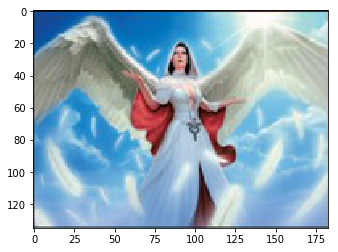

Set  0 :  AVR
(310, 223, 3)
Press to continue...
V10 :  Æther Vial.full.jpg


IndexError: list index out of range

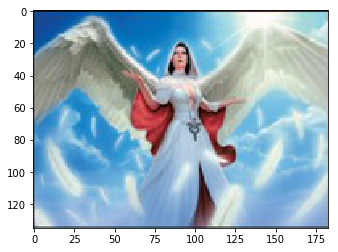

In [39]:
set_num = 18
plt.figure()
for i in range(0,len(sets_filtered)):
    temp_images = load_image(sets_filtered[i],images_path)
    test_image = temp_images[0]
    
    # plt.figure()
    # plt.imshow(test_image)

    x_dim_test = [20,203] #20,203
    # y_dim_test = [36,171]
    y_dim_test = [37,172]
    # y_dim_test = [32,167] #36,171
    # y_dim_test = [42,177]

    test_image_c = crop_image(test_image,x_dim_test, y_dim_test)
#     plt.figure()
#     plt.imshow(test_image_c)
#     time.sleep(2)
    
    # Test displaying using IPython 'display'
    plt.imshow(test_image_c)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    print("Set ", i, ": ", sets_filtered[i])
    print(test_image.shape)

    input("Press to continue...")
    #    print("No images for set %s" %sets[set_num])

### Load Images
Load images from the filtered and cropped sets. Display all cards containing the word of the subtype given.

In [9]:
def load_images_type_dim(sets, subtype, images_path_):
    pics = []
    x_dim = [20,203]
    for index, set in sets.iterrows():
        images_path = "%s/%s" % (images_path_, set['name'])
        y_dim = [set['Ya'],set['Yb']]
        
        # Load subset type cards from csv lists
        try: #Try to load the given set, if it doesn't exist, pass
            card_names = get_subtype_df(load_set(set['name']),subtype)['name'].values
            for image in card_names:
                try:
                    im_file_name = "%s.full.jpg" % image
                    #print(set, ": ", im_file_name)
                    im_file_path = "%s/%s" % (images_path, im_file_name)
                    #print(im_file_path)
                    image = np.asarray(Image.open(im_file_path))
                    image = resize(image, (310,223), mode='reflect')
                    pics.append(crop_image(image,x_dim,y_dim))
                except OSError:
                    pass
        except:
            pass
    
    return pics

### Loads filtered sets with dimensions given

52
Number of myr card images: 52
Dimensions of images: (135, 183, 3)


/opt/conda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


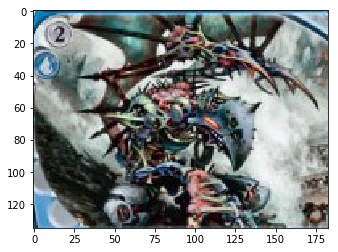

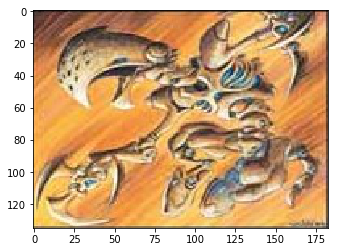

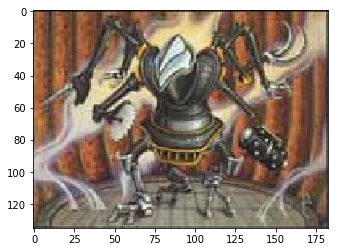

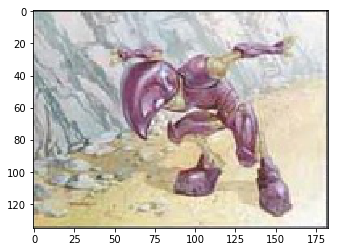

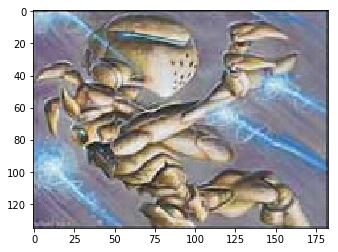

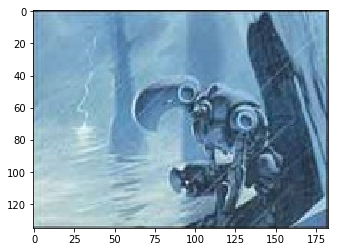

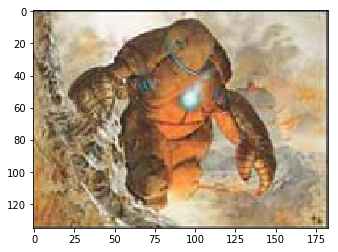

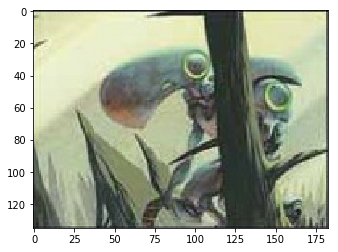

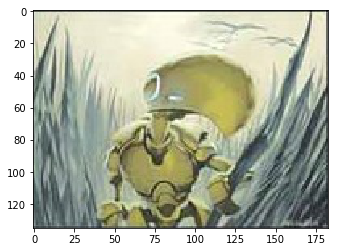

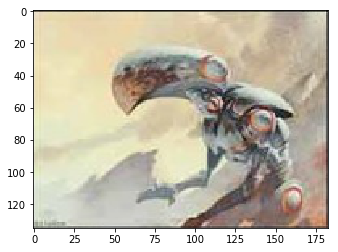

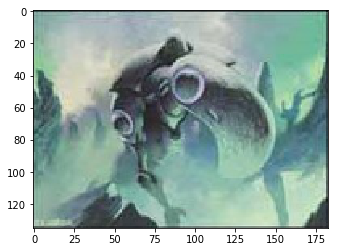

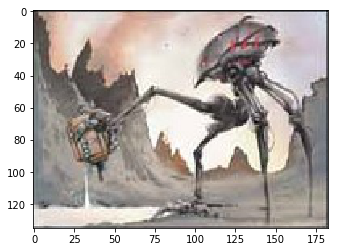

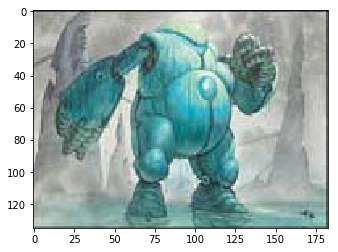

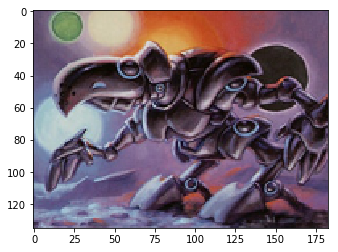

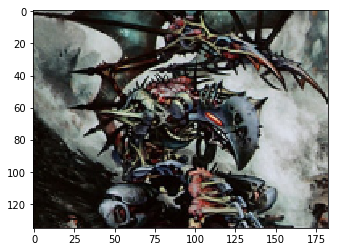

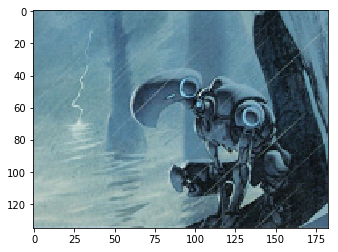

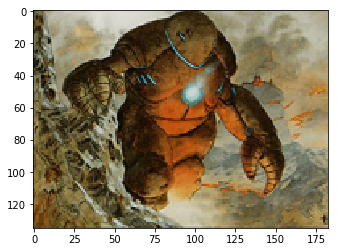

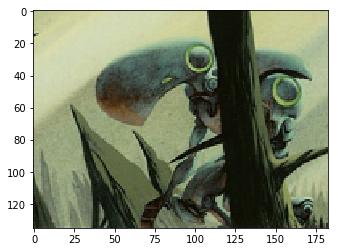

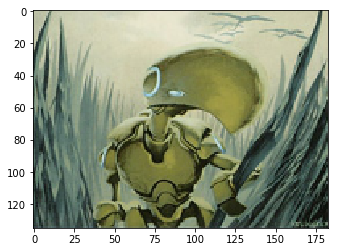

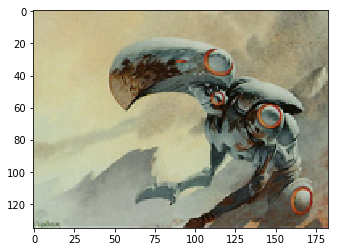

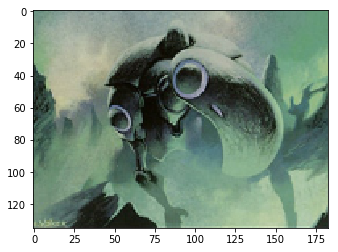

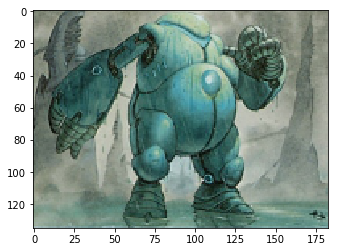

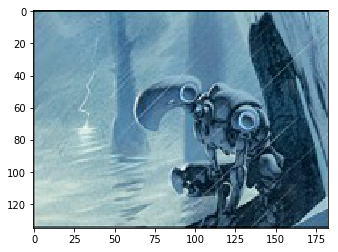

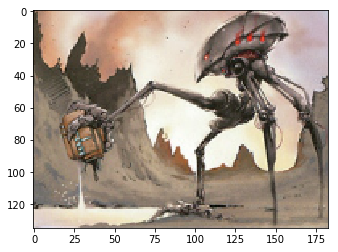

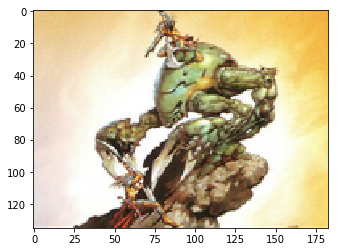

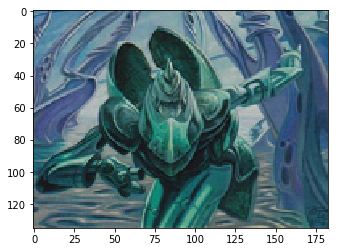

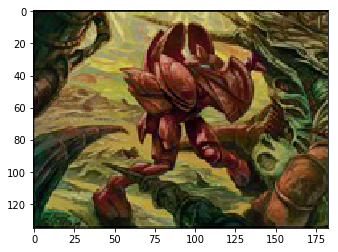

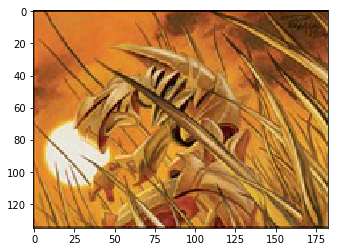

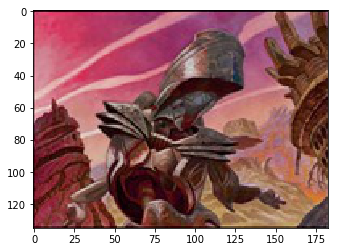

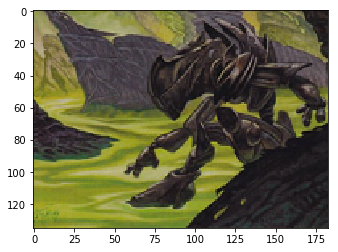

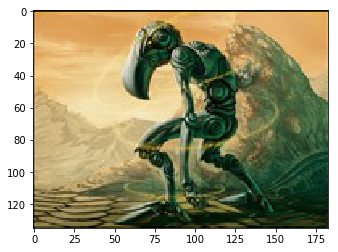

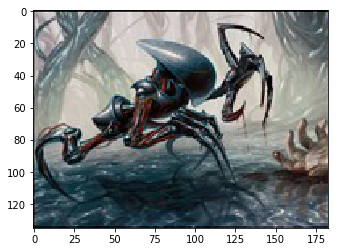

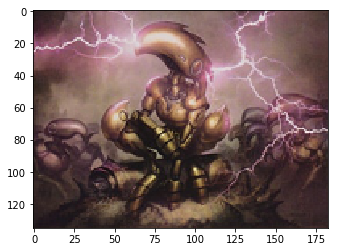

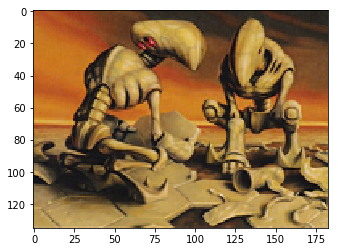

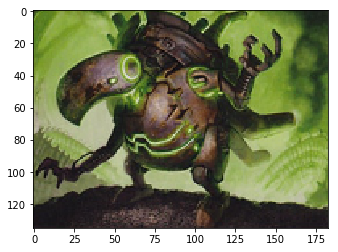

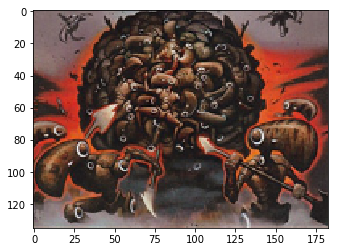

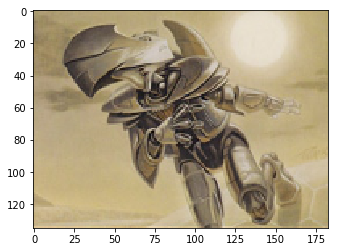

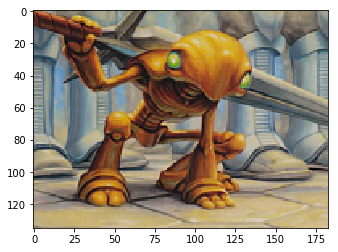

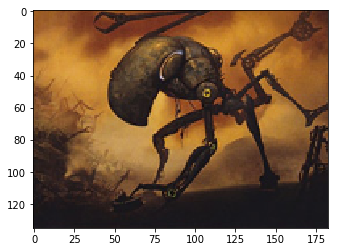

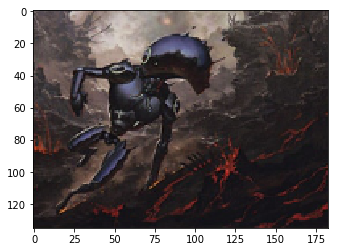

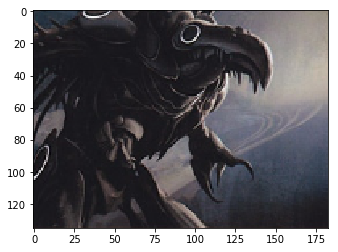

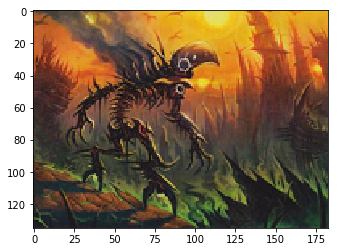

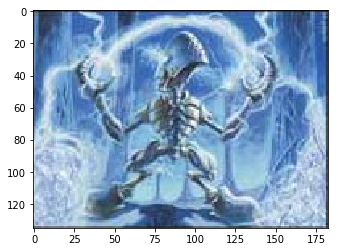

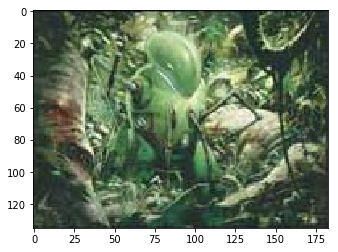

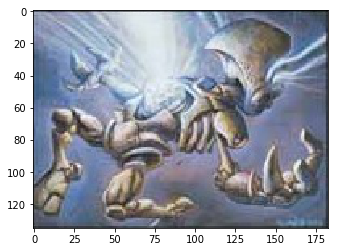

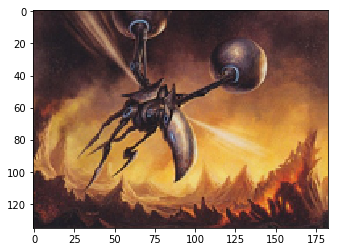

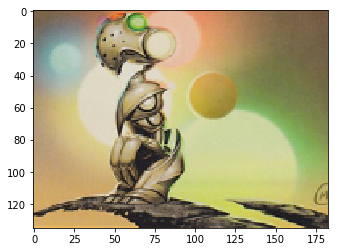

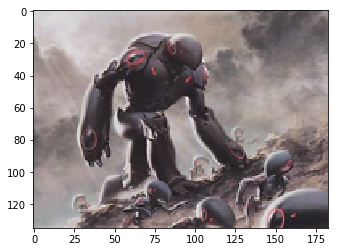

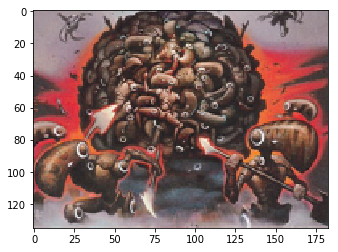

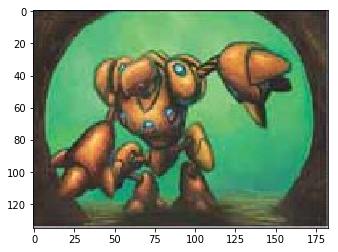

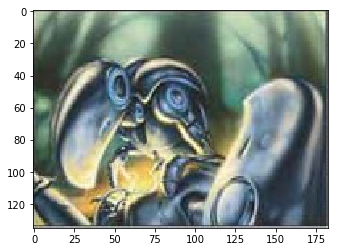

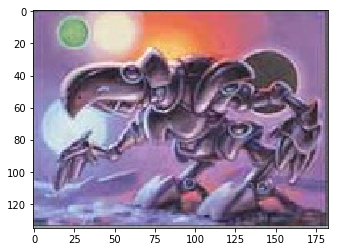

In [10]:
subtype = 'myr'

pics = load_images_type_dim(sets_dimensions, subtype, images_path)
print(len(pics))
print("Number of %s card images: %d" %(subtype, len(pics)))
print("Dimensions of images:", pics[0].shape)

for image in pics:
    plt.figure()
    plt.imshow(image)

In [38]:
#sets = ["LRW", "C14", "EVG", "DD3_EVG", "ONS", "SHM"]
subtype = 'myr'

pics_raw = load_images_type(sets, subtype, images_path)
# pics_raw = load_images('SOM', images_path)
print("Number of %s card images: %d" %(subtype, len(pics_raw)))
# Set dimensions (For SHM set only as of now)
x_dim = [20,203]
y_dim = [36,171]

# Crop images
pics_cropped = []
for image in pics_raw:
    pics_cropped.append(crop_image(image,x_dim,y_dim))
    
# Image details
print("Image Dimensions        : ", pics_raw[0].shape)
print("Cropped Image Dimensions: ", pics_cropped[0].shape)

Number of myr card images: 59
Image Dimensions        :  (310, 223, 3)
Cropped Image Dimensions:  (135, 183, 3)


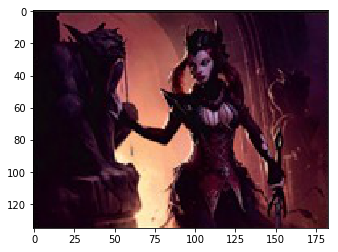

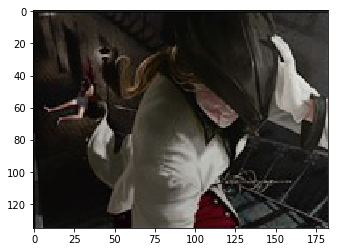

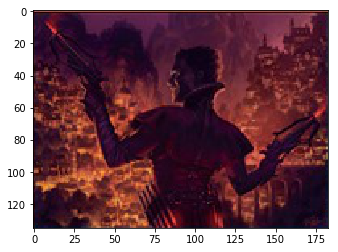

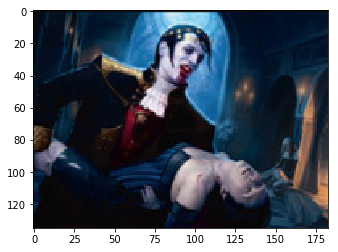

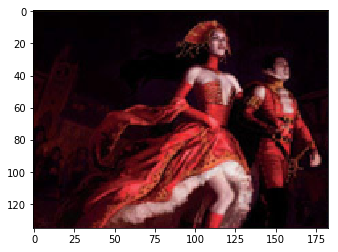

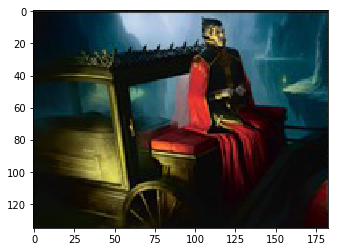

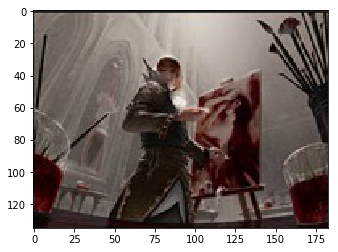

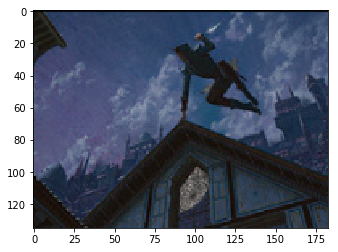

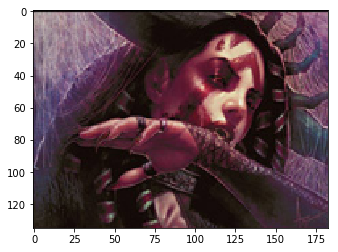

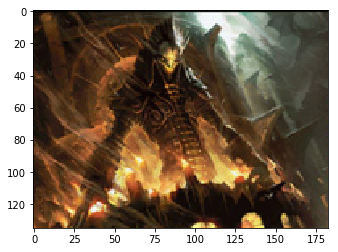

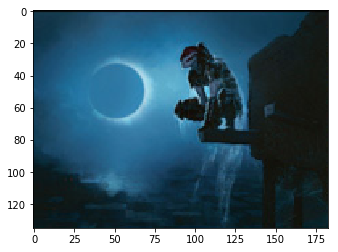

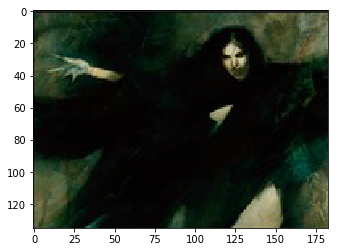

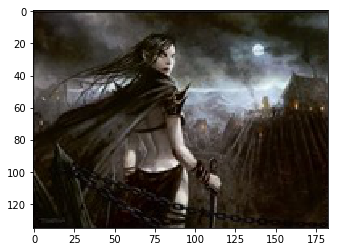

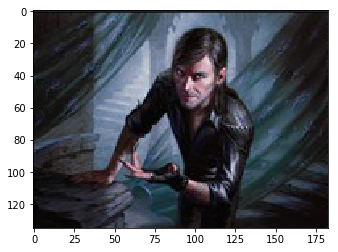

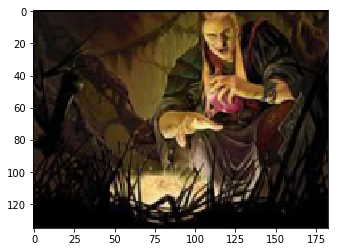

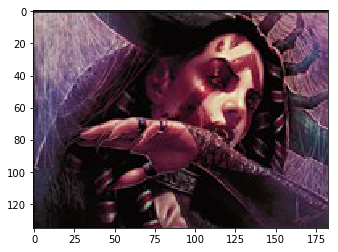

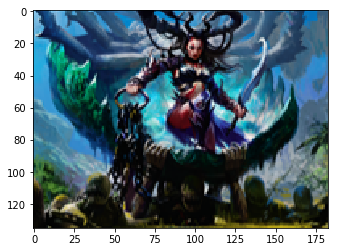

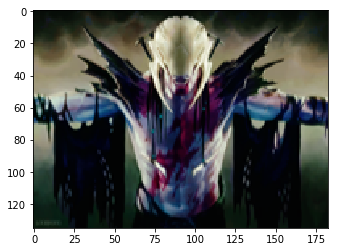

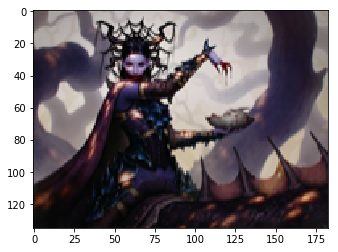

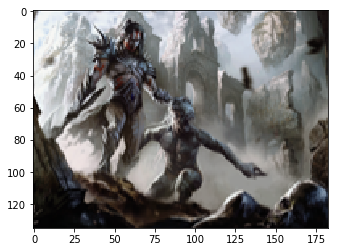

In [37]:
#Show all cards of subtype
start = 0
finish = start+20
# Show some images
for i in range(start, finish):
    plt.figure()
    plt.imshow(pics_cropped[i])

# Show all images
# for image in pics_cropped:
#     plt.figure()
#     plt.imshow(image)

(310, 223, 3)
1.0
(310, 223, 3)


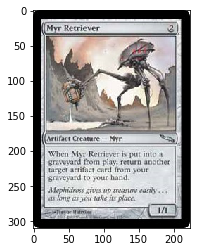

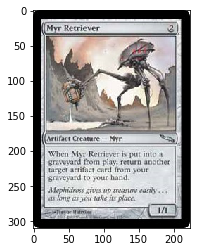

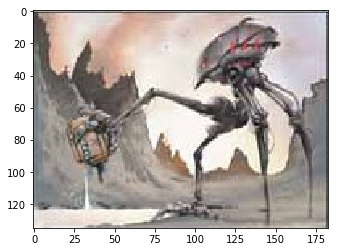

In [29]:
pic_use = pics_raw[11]
print(pic_use.shape)
print(np.max(pic_use))
plt.figure()
plt.imshow(pic_use)
resized = resize(pic_use, (310,223), mode='reflect')
print(resized.shape)
plt.figure()
plt.imshow(resized)

plt.figure()
plt.imshow(crop_image(resized,x_dim,y_dim))

In [ ]:
# Display some sample images
# for image in pics_cropped:
#     plt.figure()
#     plt.imshow(image)
start = 0
finish = start+15
for i in range(start,finish):#len(pics_raw)):
    print(pics_raw[i].shape)
    plt.figure()
    plt.imshow(pics_raw[i])

In [ ]:
# Numpy array of the image
pic_test = pics_raw[0]/bb
print(pic_mat.shape)

# Crop image display to only show card art
plt.xlim(x_dim[0],x_dim[1])
plt.ylim(y_dim[0],y_dim[1])
plt.gca().invert_yaxis()
plt.imshow(pic_mat)

In [ ]:
import sys
sys.version